In [ ]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install pyarrow

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Data

Data from 51 different sensors has been chosen, utilizing a train set consisting of 496800 samples and a test set with 449919 samples. Naturally, the train set can be expected to show normal behavior. This will be checked regardless.

In [4]:
train = pd.read_csv('data-raw/train.csv', delimiter = ',', skipinitialspace = True)
test = pd.read_csv('data-raw/test.csv', delimiter = ',', skipinitialspace = True)

In [5]:
train.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


In [6]:
test.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,?
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,?
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,?
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,?
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,?


It can be seen the dataset contains multiple signals taken every second from various sensors. The test dataset contains no labels. The aim of the LSTM autoencoder will be to determine those and then compare them against the ground truth.

Check whether all data in train is normal.

In [7]:
length = train.shape[0]
filteredLength = train[train['Normal/Attack'] == 'Normal'].shape[0]
print(filteredLength / length)

1.0


It can be seen that it is.

# Visualization

In [8]:
def visualize_sensor_data(df, window=None, sensors=None):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

/Users/ignacunado/Documents/Ignacio/GitHub/sensor-anomalies/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


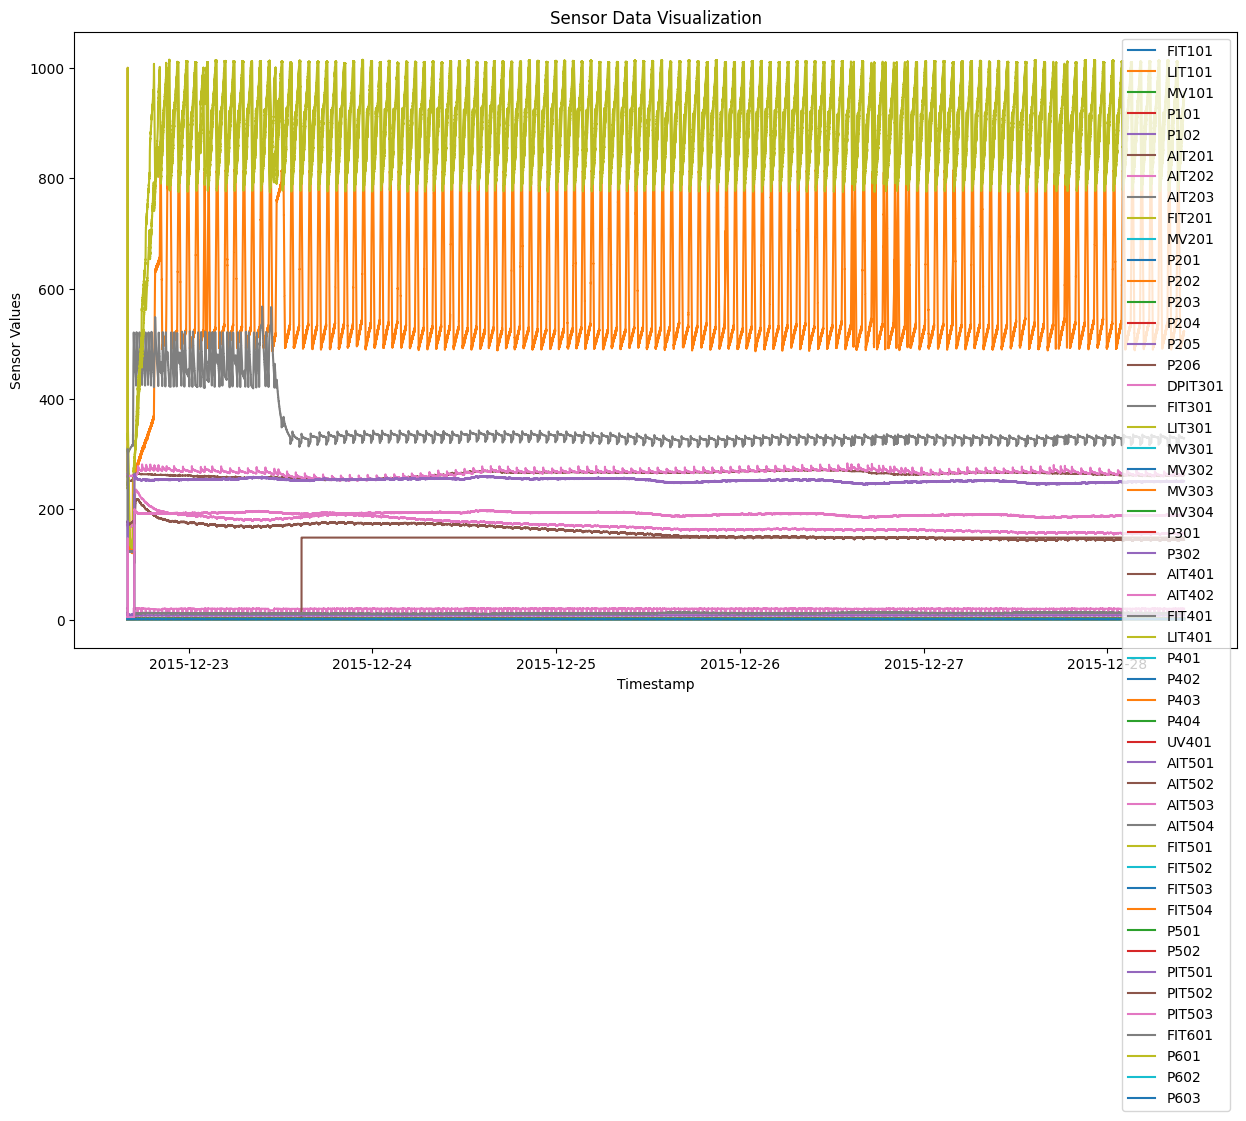

In [14]:
visualize_sensor_data(train)

It is clear that some signals are correlated, others show cyclical behavior, and others have discrete outputs (analog). Moreover, some initialization can be seen at the beginning, and it takes some time for the signals to reach their regular values. In order to build a good anomaly detector, the first datapoints will be removed to get the train data behaving as normally as possible.

/var/folders/0x/klqdyhpj427dvg81kxzyfcvm0000gn/T/ipykernel_86616/4253043836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
/Users/ignacunado/Documents/Ignacio/GitHub/sensor-anomalies/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


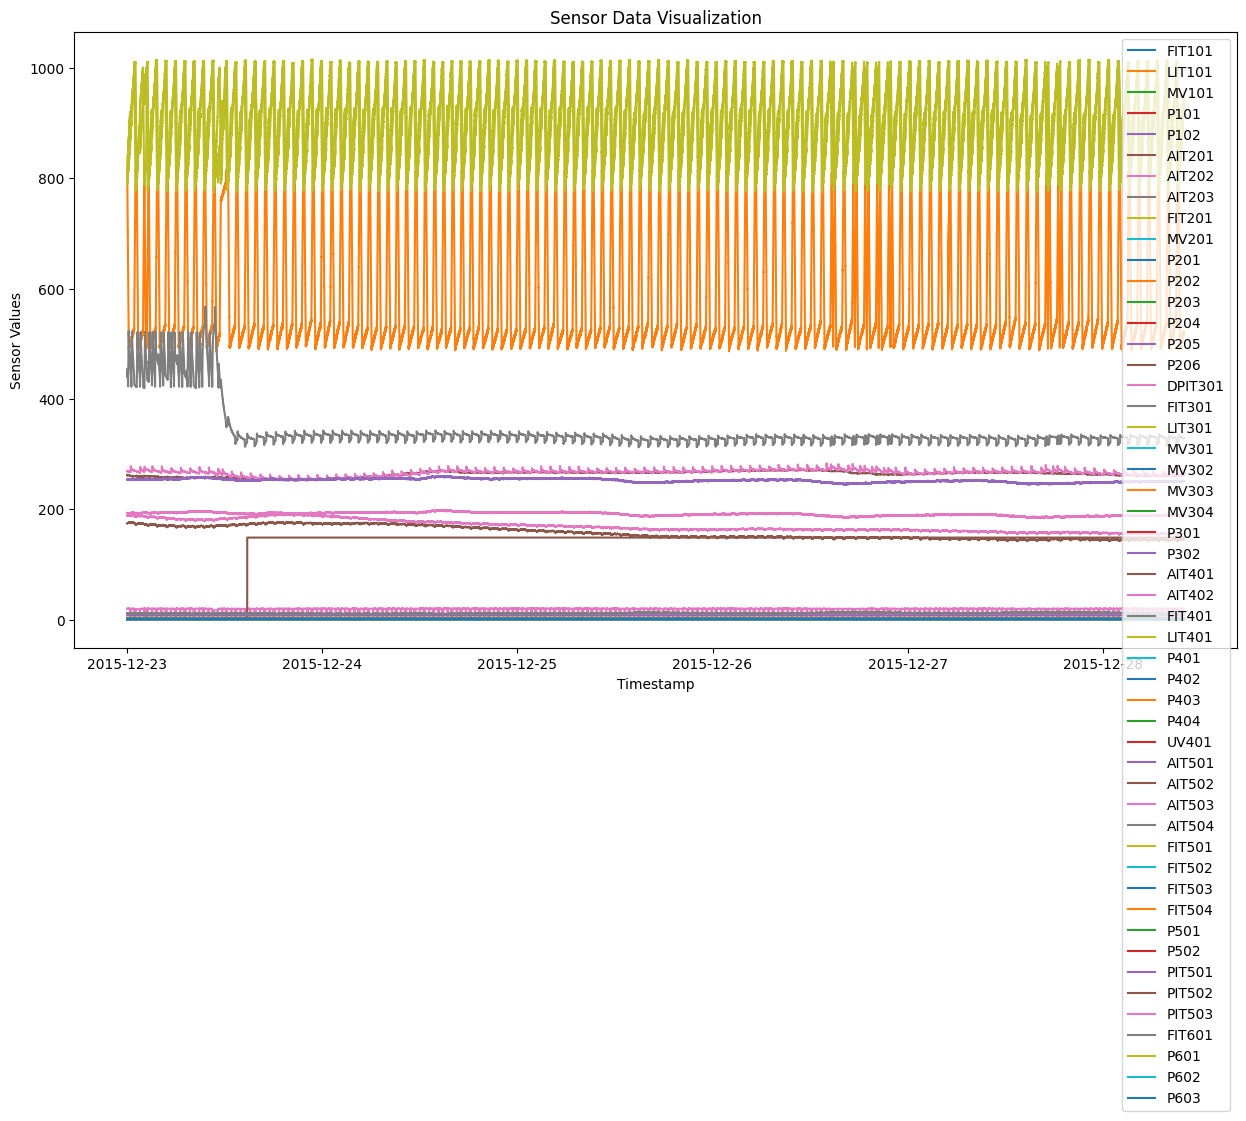

In [10]:
visualize_sensor_data(train[train['Timestamp'] > '2015-12-23'])

Great, train data now shows normal behavior. How does the test data look?

/Users/ignacunado/Documents/Ignacio/GitHub/sensor-anomalies/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


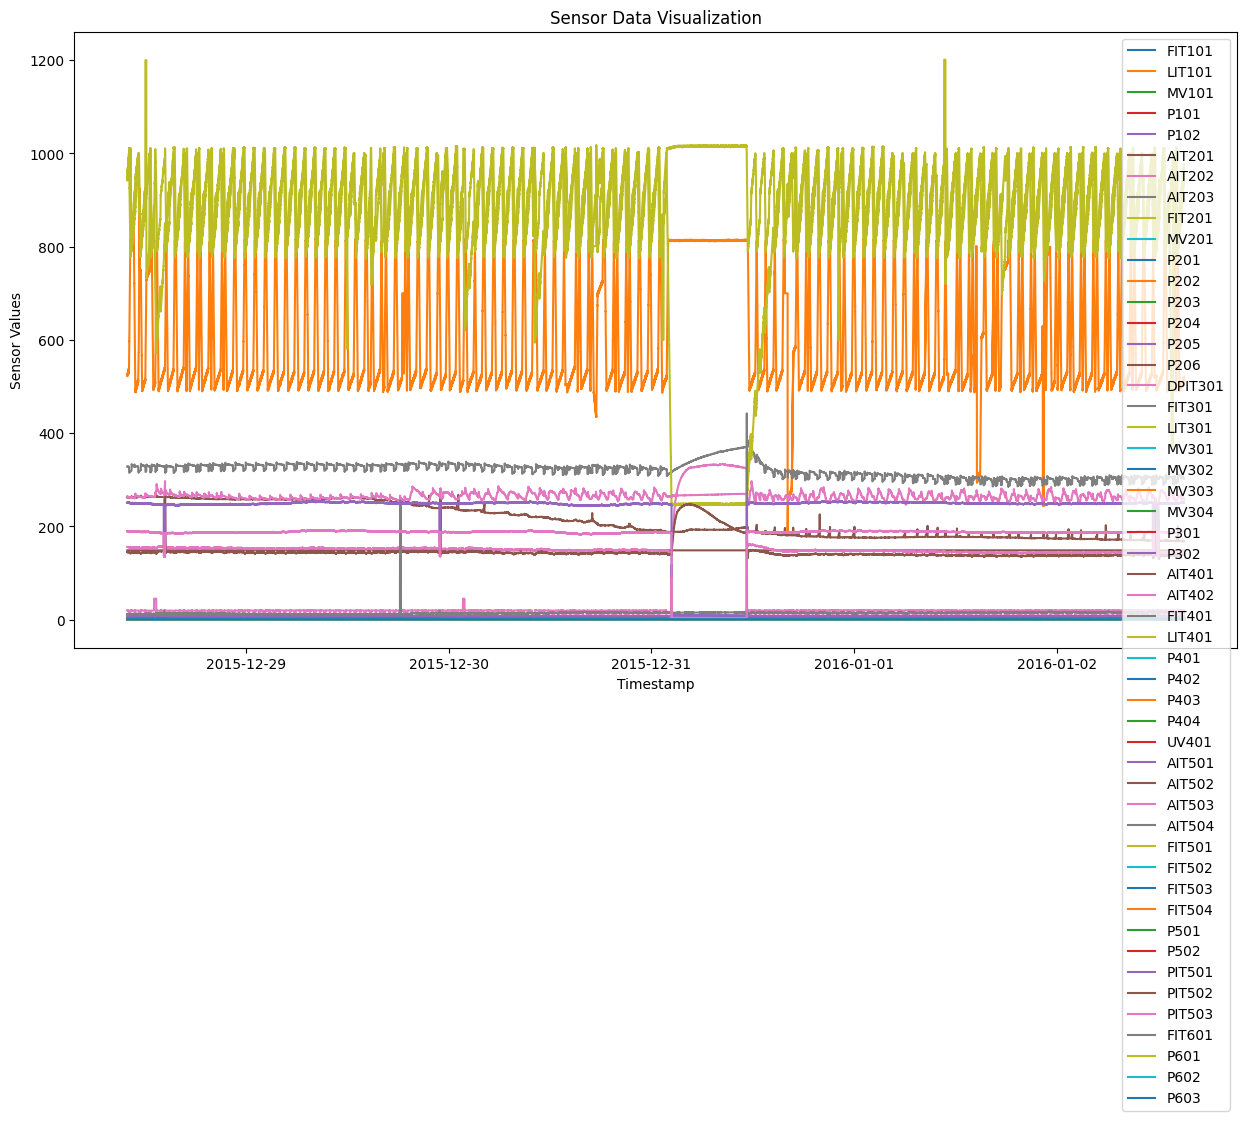

In [11]:
visualize_sensor_data(test)

It is clear that this test data shows weird behavior and many anomalies.

# Choosing a signal
Sensor LIT101 will be used to check for anomalies, as it shows some interesting cyclical beahavior and clear anomalies.

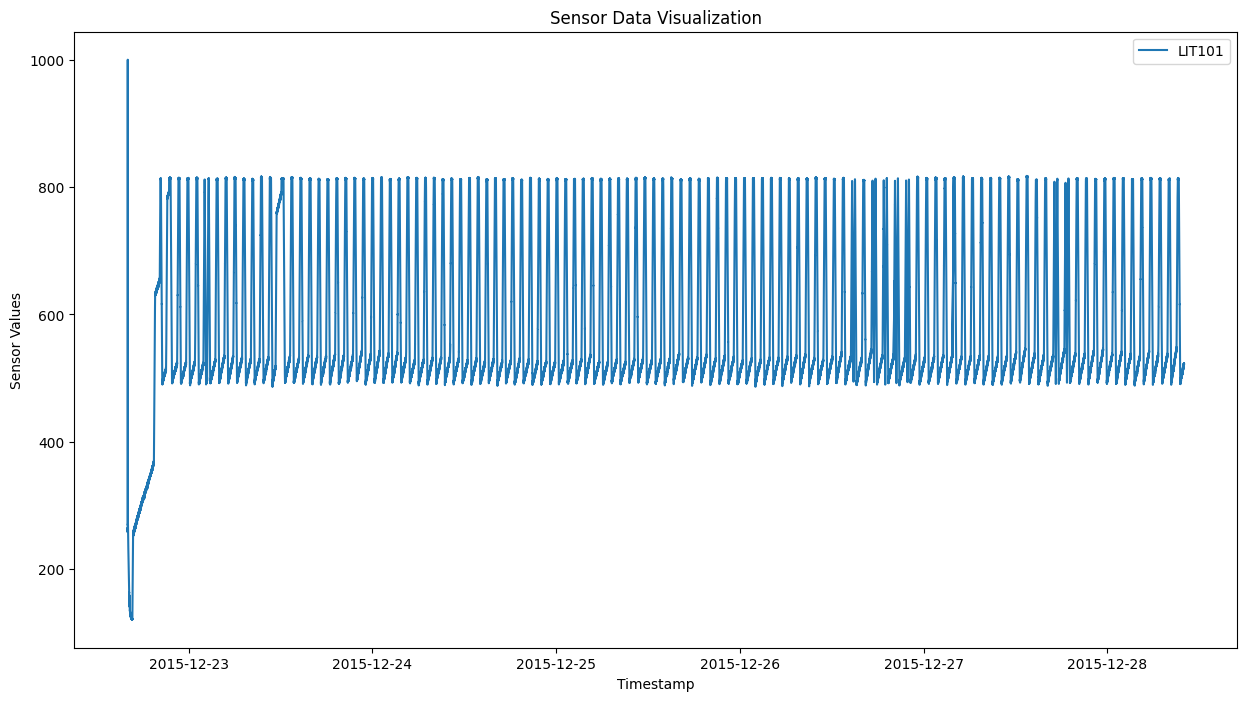

In [12]:
visualize_sensor_data(train, sensors=['LIT101'])

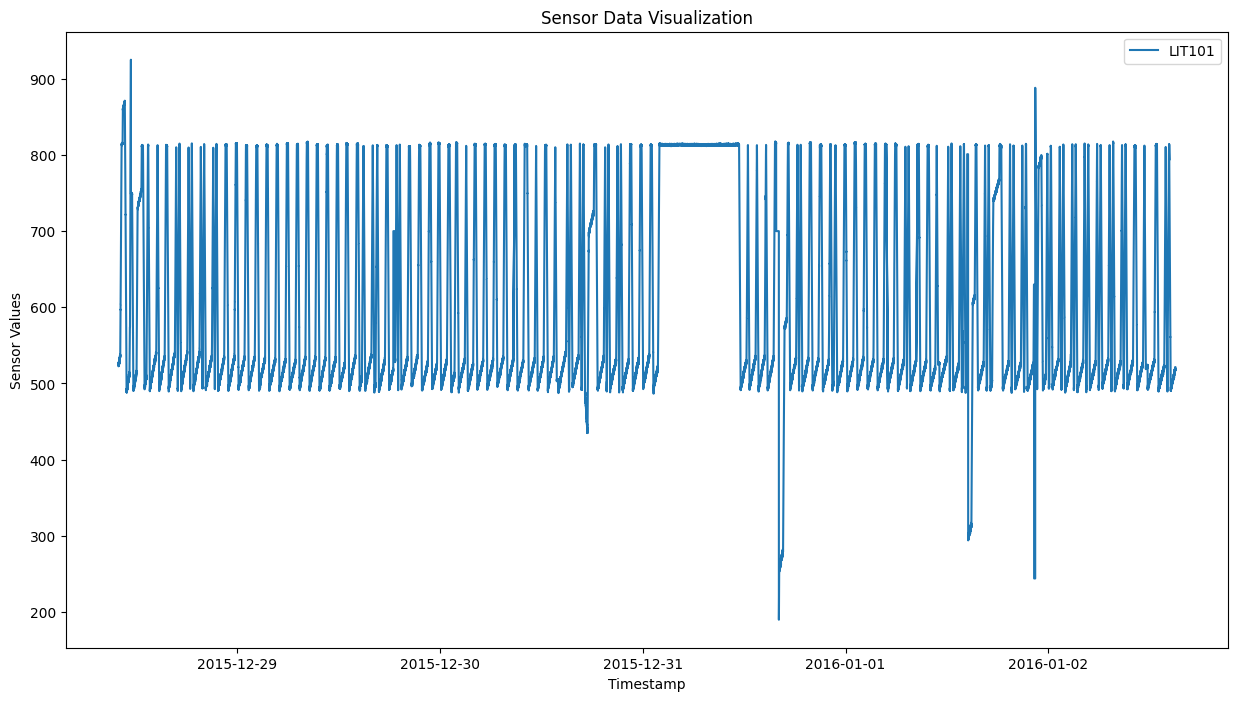

In [13]:
visualize_sensor_data(test, sensors=['LIT101'])